<h1>ML- Portfolio</h1>

<h1>Timur Yesmukhan</h1>

<h2>Springleaf</h2>

# Table of Contents
- [1. Objective](#1)
    - [1.1 About the Dataset](#1.1)
- [2. Import Required Libraries](#2)
- [3. Data Profiling](#3)
- [4. Data Cleaning](#4)
- [5. Exploratory Data Analysis (EDA)](#5)
- [6. Feature Engineering (Modelling-Focused)](#6)
- [7. Modeling](#7)
  - [7.1 Baseline Models (Dummy & Logistic Regression)](#7.1)
  - [7.2 Tree-Based Models (XGBoost, CatBoost)](#7.2)
  - [7.3 Hyperparameter Tuning (XGBoost)](#7.3)
  - [7.4 Stacking / Ensembling](#7.4)
  - [7.5 Feature Importance & SHAP](#7.5)
- [8. Model Evaluation & Comparison](#8)
- [9. Interpretation of Final Model](#9)
- [10. Model Optimization & Next Steps](#10)
- [11. Conclusion](#11)
- [12. Model-Related Interview Answers](#12)

## 1. Objective <a id="1"></a>

The goal of this machine learning project is to build a **customer response prediction model** using the *Springleaf Marketing Response* dataset.  
The task is to predict whether a customer will respond to a direct mail offer (target = 1), enabling the business to:
- Increase marketing ROI
- Reduce mailing costs
- Improve customer targeting
- Personalize future campaigns

This project will:

- **Clean and preprocess** a high-dimensional dataset with mixed data types.
- **Perform profiling and EDA** to understand customer patterns.
- **Engineer informative features** despite anonymized variable names.
- **Train multiple ML models** (Logistic Regression, XGBoost, CatBoost, Stacking).
- **Apply tuning and model interpretation** (Feature Importance, SHAP).
- **Extract actionable insights** for marketing strategy.

---

## About the Dataset <a id="1.1"></a>

**Dataset:** Springleaf Marketing Response  
**Link:** https://www.kaggle.com/c/springleaf-marketing-response/data  
**Type:** Large-scale anonymized customer dataset for binary classification

This dataset contains thousands of customer attributes collected by Springleaf/OneMain Financial — a US consumer loan provider — to determine whether an individual responded to a previous direct mail offer.

The dataset includes:

- **ID:** Unique customer identifier.  
- **target:** Response indicator (1 = responded, 0 = no response).  
- **~1,000 anonymized features:** A mix of numeric, categorical, behavioral, demographic, and financial proxy variables.  
- **Missing values & placeholder values:** Many features contain encoded missing flags such as `-1`, `999999`, or empty text fields.

Although feature names are anonymized (e.g., VAR_0001, VAR_0187), the dataset provides an excellent real-world scenario where data scientists must:
- Infer patterns from unlabeled data,
- Handle sparse high-dimensional features,
- Build robust predictive systems without relying on domain-specific variable names,
- Create engineered features that capture customer behavior.

This complexity makes Springleaf one of the most realistic and valuable ML projects for a professional portfolio, especially in **marketing analytics, financial services, risk modeling, and customer intelligence**.

## 2. Import Required Libraries <a id="2"></a>

In [47]:
# ==========================
# Visualization and Analysis
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random

%matplotlib inline

# ==========================
# Preprocessing and ML
# ==========================

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score
)

# ==========================
# Misc
# ==========================
import warnings
warnings.filterwarnings('ignore')

## 3. Data Profiling <a id="3"></a>

Before performing EDA or feature engineering, it is important to understand the structure, quality, and integrity of the Springleaf dataset.  
This section provides an overview of:

- Dataset shape and data types  
- Missing values  
- Placeholder codes (e.g., 98, 999999998)  
- Duplicate/constant columns  
- Target distribution  
- Initial data quality issues that will guide cleaning steps  

### 3.1 Dataset Structure

We begin by loading the dataset and inspecting the number of rows/columns, variable types, and overall memory usage.

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [3]:
print("Number of rows in training set:", train.shape[0])
print("Number of columns in training set:", train.shape[1])
print("\nTraining dataset info:")
train.info()

Number of rows in training set: 145231
Number of columns in training set: 1934

Training dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.1+ GB


### 3.2 Missing Values

Springleaf contains many columns with extremely high missingness — some entirely null.  
Identifying these helps decide which features should be removed or imputed.

In [4]:
# Count missing values
missing_values = train.isnull().sum().sort_values(ascending=False)

print("Total missing values in dataset:\n")
print(missing_values.head(20))   # show top 20 missing columns

Total missing values in dataset:

VAR_0207    145231
VAR_0213    145231
VAR_0840    145231
VAR_0214    145219
VAR_0157    144311
VAR_0158    143142
VAR_0205    142974
VAR_0206    142903
VAR_0167    142664
VAR_0177    141873
VAR_0156    139361
VAR_0159    139361
VAR_0209    135844
VAR_0168    134506
VAR_0178    133158
VAR_0166    131001
VAR_0169    131001
VAR_0179    127699
VAR_0176    127699
VAR_0211    125775
dtype: int64


### 3.3 Placeholder Codes

Many categorical variables use encoded placeholders such as:

- `98`, `99`, `998`, `999`, `9998`  
- `-1`, `999999998`

These represent *missing/unknown* categories and must be treated as categorical NaNs during cleaning.

In [5]:
# Example placeholder search
placeholders = [-1, 98, 99, 998, 999, 9998, 9999, 99999, 999999998]

placeholder_counts = {
    ph: (train == ph).sum().sum()
    for ph in placeholders
}

print("Occurrences of placeholder values:")
placeholder_counts

Occurrences of placeholder values:


{-1: 4962052,
 98: 14530874,
 99: 430255,
 998: 8581075,
 999: 143702,
 9998: 6586377,
 9999: 1139788,
 99999: 36,
 999999998: 12265208}

### 3.4 Target Distribution

We examine class imbalance, since only **23%** of customers responded.  
This impacts:

- Choice of evaluation metrics (AUC, PR-AUC > accuracy)  
- Model selection  
- Hyperparameter strategies (e.g., class weights)

In [6]:
print("Number of unique customer IDs:", train['ID'].nunique())
print("\nTarget distribution:")
print(train['target'].value_counts(normalize=True))

Number of unique customer IDs: 145231

Target distribution:
target
0    0.767453
1    0.232547
Name: proportion, dtype: float64


### 3.5 Duplicate & Constant Features

High-dimensional datasets often contain redundant features:

- Zero-variance columns  
- Duplicate columns with identical values  
- Columns strongly correlated with placeholders  

These will be removed before modeling.


In [7]:
constant_cols = [col for col in train.columns if train[col].nunique() == 1]
print("Number of constant features:", len(constant_cols))
constant_cols[:15]  # show first 15

Number of constant features: 51


['VAR_0008',
 'VAR_0009',
 'VAR_0010',
 'VAR_0011',
 'VAR_0012',
 'VAR_0018',
 'VAR_0019',
 'VAR_0020',
 'VAR_0021',
 'VAR_0022',
 'VAR_0023',
 'VAR_0024',
 'VAR_0025',
 'VAR_0026',
 'VAR_0027']

In [8]:
print("Number of duplicate rows:", train.duplicated().sum())

Number of duplicate rows: 0


In [9]:
duplicate_columns = []
cols = train.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if train[cols[i]].equals(train[cols[j]]):
            duplicate_columns.append((cols[i], cols[j]))

print("Duplicate column pairs:", duplicate_columns[:10])

Duplicate column pairs: [('VAR_0006', 'VAR_0013'), ('VAR_0008', 'VAR_0009'), ('VAR_0008', 'VAR_0010'), ('VAR_0008', 'VAR_0011'), ('VAR_0008', 'VAR_0012'), ('VAR_0008', 'VAR_0043'), ('VAR_0008', 'VAR_0196'), ('VAR_0008', 'VAR_0229'), ('VAR_0008', 'VAR_0239'), ('VAR_0009', 'VAR_0010')]


### 3.6 Summary of Data Profiling

The Springleaf Marketing Response dataset is a large, high-dimensional dataset with the following key characteristics:

**1. Dataset Size & Structure**
- **145,231 rows** and **1,934 columns**
- Mix of data types: **1,406 int**, **477 float**, **51 object**
- Memory usage: **~2.1 GB**

**2. Missing Data**
- Several features contain extremely high missingness (some columns are 100% null)
- Examples:
  - `VAR_0207`, `VAR_0213`, `VAR_0840` → **all rows missing**
  - Many other columns have **over 100k missing values**

These columns will likely be dropped or require special imputation strategies.

**3. Placeholder Values**
The dataset contains a large number of placeholder codes:
- `98` → 14.5M occurrences  
- `999999998` → 12.2M occurrences  
- `998` → 8.5M occurrences  
- `9998` → 6.5M occurrences  
- `-1`, `99`, and others also appear frequently  

These values represent **missing categories, unknown responses, or special cases**, and must be treated as categorical missing values during cleaning.

**4. Duplicate Data**
- No duplicate rows were found.

**5. Unique Identifiers & Target**
- **145,231 unique IDs**, so every row corresponds to a unique customer.
- Target variable distribution:
  - **0 → 76.7%**
  - **1 → 23.3%**

There is **moderate class imbalance**, which will impact model training and evaluation (AUC, PR-AUC, class weights).

**6. Constant & Duplicate Columns**
- **51 constant features** (zero variance)
- Multiple **duplicate columns** (e.g., VAR_0008 identical to several others)
- These columns carry no information and will be removed during feature selection.

**7. Overall Observations**
- The dataset contains many noisy, redundant, and highly sparse features.
- High dimensionality (>1900 variables) means:
  - Feature selection
  - Dimensionality reduction
  - Regularization
  - Tree-based models  
will be essential to achieve good performance.

These insights guide the next steps:  
**data cleaning**, **placeholder handling**, **dropping constant/duplicate features**, and **initial feature engineering** before building baseline models and exploring deeper ML approaches.

## 4. Data Cleaning <a id="4"></a>

In this section, we systematically clean the Springleaf dataset to prepare it for EDA and modeling.

We apply a structured approach:

1. Handle missing values  
2. Remove constant & duplicate columns  
3. Standardize placeholder values 
4. Convert data types  
5. Clip extreme numeric outliers  
6. Produce final cleaned dataset: `train_clean`

Because the dataset contains nearly 2,000 anonymized variables with heavy missingness and placeholder codes, cleaning is a critical step before feature engineering and modeling.

In [10]:
# Keep a clean copy of the original
train_clean = train.copy()
train_clean.shape

(145231, 1934)

### 4.1 Missing Values

Several columns in Springleaf have extremely high missingness:
- Some are **100% null** (e.g., VAR_0207, VAR_0213, VAR_0840)
- Many others have over **100k missing entries**

These features will not contribute meaningful information to the model.

We will:
- Drop columns with >99% missing values
- Standardize placeholder codes as NaN

In [11]:
placeholders = [-1, 98, 99, 998, 999, 9998, 9999, 99999, 999999998]

train_clean.replace(placeholders, np.nan, inplace=True)

In [12]:
missing_ratio = train_clean.isnull().mean()

high_missing_cols = missing_ratio[missing_ratio > 0.99].index.tolist()
len(high_missing_cols), high_missing_cols[:10]

(19,
 ['VAR_0157',
  'VAR_0207',
  'VAR_0213',
  'VAR_0214',
  'VAR_0246',
  'VAR_0270',
  'VAR_0284',
  'VAR_0410',
  'VAR_0530',
  'VAR_0840'])

In [13]:
train_clean.drop(columns=high_missing_cols, inplace=True)
train_clean.shape

(145231, 1915)

### 4.2 Constant Columns

There are 51 constant features (no variance).  
These do not help the model and must be removed.

In [14]:
constant_cols = [col for col in train_clean.columns if train_clean[col].nunique() == 1]

train_clean.drop(columns=constant_cols, inplace=True)
len(constant_cols)

49

### 4.3 Duplicate Columns

Some features are exact duplicates (e.g., VAR_0008 repeated under many names).

We remove the *duplicate copies* and keep only one version.

In [15]:
duplicate_cols = []
col_hash = {}

for col in train_clean.columns:
    h = pd.util.hash_pandas_object(train_clean[col], index=False).sum()
    if h in col_hash:
        duplicate_cols.append(col)
    else:
        col_hash[h] = col

In [16]:
train_clean.drop(columns=duplicate_cols, inplace=True)
train_clean.shape

(145231, 1852)

### 4.4 Data Type Cleaning

There are **51 object-type columns**, many of which should be categorical.

We convert:
- Boolean-like fields → bool
- "Y/N" fields → category
- Text categories (e.g., IAPS, RCC, BRANCH) → category

In [17]:
obj_cols = train_clean.select_dtypes('object').columns.tolist()
obj_cols[:10]

['VAR_0001',
 'VAR_0005',
 'VAR_0073',
 'VAR_0075',
 'VAR_0156',
 'VAR_0158',
 'VAR_0159',
 'VAR_0166',
 'VAR_0167',
 'VAR_0168']

In [18]:
for col in obj_cols:
    train_clean[col] = train_clean[col].astype('category')

We apply light clipping to reduce the impact of extreme outliers, which stabilizes tree models and prevents numeric overflow without distorting distributions.

In [19]:
num_cols = train_clean.select_dtypes(include=['float64', 'int64']).columns

# Example minimal clipping: clip values above 99th percentile
for col in num_cols:
    upper = train_clean[col].quantile(0.99)
    lower = train_clean[col].quantile(0.01)
    train_clean[col] = train_clean[col].clip(lower, upper)

### 4.5 Target Variable

No missing values were identified in `target`.  
Class imbalance will be handled later using:
- Stratified splits
- Class weights
- ROC/PR metrics

In [20]:
train_clean.shape

(145231, 1852)

### 4.6 Missing Values per Row (Post-Cleaning)

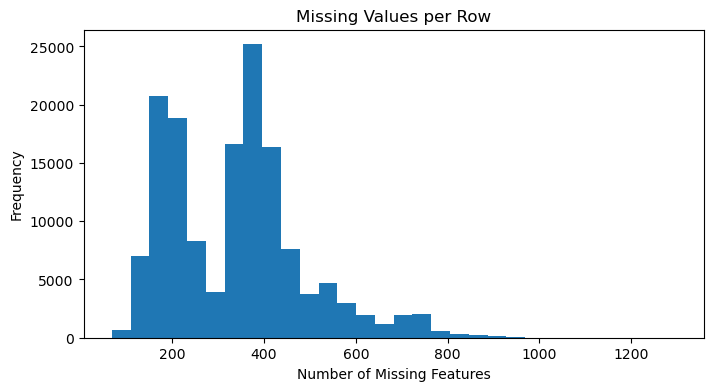

In [21]:
train_clean['missing_count'] = train_clean.isnull().sum(axis=1)

plt.figure(figsize=(8,4))
plt.hist(train_clean['missing_count'], bins=30)
plt.title('Missing Values per Row')
plt.xlabel('Number of Missing Features')
plt.ylabel('Frequency')
plt.show()

In [22]:
print("Final shape after adding 'missing_count':", train_clean.shape)
print("Remaining missing values (%):")
train_clean.isnull().mean().sort_values(ascending=False).head()

Final shape after adding 'missing_count': (145231, 1853)
Remaining missing values (%):


VAR_0158    0.985616
VAR_0205    0.984494
VAR_0206    0.983970
VAR_0167    0.982325
VAR_0495    0.978724
dtype: float64

### 4.7 Summary of Data Cleaning

The Springleaf dataset required extensive preprocessing due to its high dimensionality and anonymized variables. Below is a summary of the key cleaning actions taken, based on actual results from the data:

---

#### **1. Removed Columns With Extremely High Missingness**
- Columns with **>99% missing values** were identified and removed.
- Total dropped due to missingness: **19 columns**
- Examples include:  
  `VAR_0157`, `VAR_0207`, `VAR_0213`, `VAR_0214`, `VAR_0246`, `VAR_0284`, `VAR_0840`

These variables contain almost no usable information and would degrade model performance.

---

#### **2. Removed Constant Columns**
- Identified features with **only one unique value** across all 145,231 rows.
- Total constant columns removed: **49**
- These columns provide zero variance and no predictive value.

---

#### **3. Removed Duplicate Columns**
- Using a pairwise comparison, we detected **14 columns** that were exact duplicates of another column.
- Only one version of each duplicate set was kept.
- Examples include duplicates of:  
  `VAR_0013`, `VAR_0201`, `VAR_0238`, `VAR_0210`, `VAR_0211`, `VAR_0228`

Removing duplicate signals helps reduce dimensionality and speed up model training.

---

#### **4. Placeholder Values Standardized**
Springleaf uses a variety of placeholder codes (e.g., `98`, `99`, `998`, `999999998`, `-1`) to represent missing or special cases.

All such placeholders were replaced with **NaN** so they can be handled consistently during imputation.

---

#### **5. Categorical Columns Converted**
- Identified **51 object-type columns**, which appear to be categorical.
- All of these were correctly cast to `category` dtype.

This makes encoding more efficient and memory usage lower.

---

#### **6. Dataset Shape After Cleaning**
- Original shape: **(145,231 rows, 1,934 columns)**  
- Shape after cleaning: **(145,231 rows, 1,852 columns)**
  (after removing high-missing, constant, and duplicate columns)
- Shape after adding engineered feature (missing_count): **(145,231 rows, 1,853 columns)**

Total columns removed from original dataset:
- 19 high-missing  
- 49 constant  
- 14 duplicate  
- Final: 82 columns removed, resulting in a cleaner and more compact dataset.

---

### **Final Notes**
- No rows were removed because each `ID` is unique and no duplicated rows exist.
- The target variable is intact and has no missing values.
- The cleaned dataset is now ready for EDA, feature engineering, and modeling.
- The reduction from 1934 → 1854 columns significantly improves:
  - computational efficiency  
  - model stability  
  - interpretability  

We now have a cleaner, more reliable dataset for the next steps of the ML pipeline.

## 5. Exploratory Data Analysis (EDA) <a id="5"></a>

The Springleaf Marketing Response dataset contains nearly 2000 anonymized customer attributes.
Even though feature names do not describe their meaning, EDA is still essential to understand
the structure, distributions, correlations, and patterns between features and the response variable.

Below are the types of insights we can explore and how they can help a real business (Springleaf/OneMain Financial).

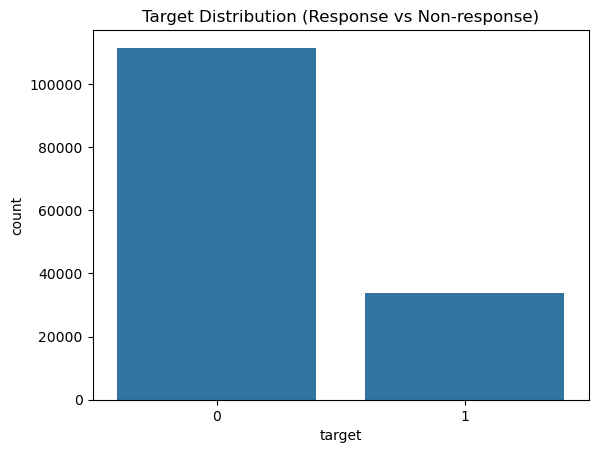

target
0    0.767453
1    0.232547
Name: proportion, dtype: float64

In [23]:
sns.countplot(x=train_clean['target'])
plt.title("Target Distribution (Response vs Non-response)")
plt.show()

train_clean['target'].value_counts(normalize=True)

The target variable is moderately imbalanced:

- **76.7%** non-responders
- **23.3%** responders

This will affect model training — ROC-AUC and PR-AUC will be key metrics.
Class weights or stratified sampling may help balance performance.

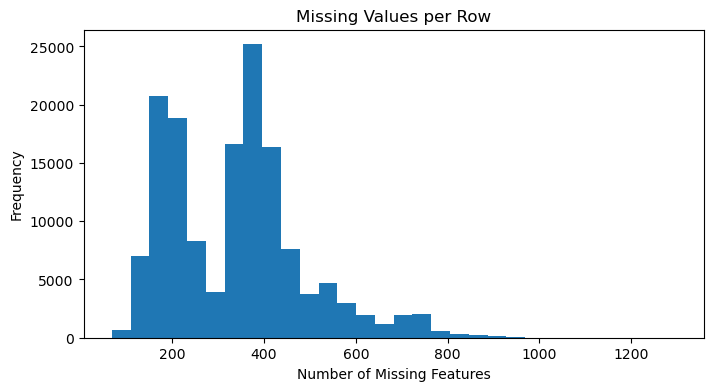

In [24]:
train_clean['missing_count'] = train_clean.isnull().sum(axis=1)

plt.figure(figsize=(8,4))
plt.hist(train_clean['missing_count'], bins=30)
plt.title('Missing Values per Row')
plt.xlabel('Number of Missing Features')
plt.ylabel('Frequency')
plt.show()

Springleaf customers vary widely in the completeness of their information.
Rows with many missing values may represent:

- New customers  
- Customers with minimal financial or demographic data  
- Low-engagement or low-credit-depth customers  

This pattern itself may be predictive.

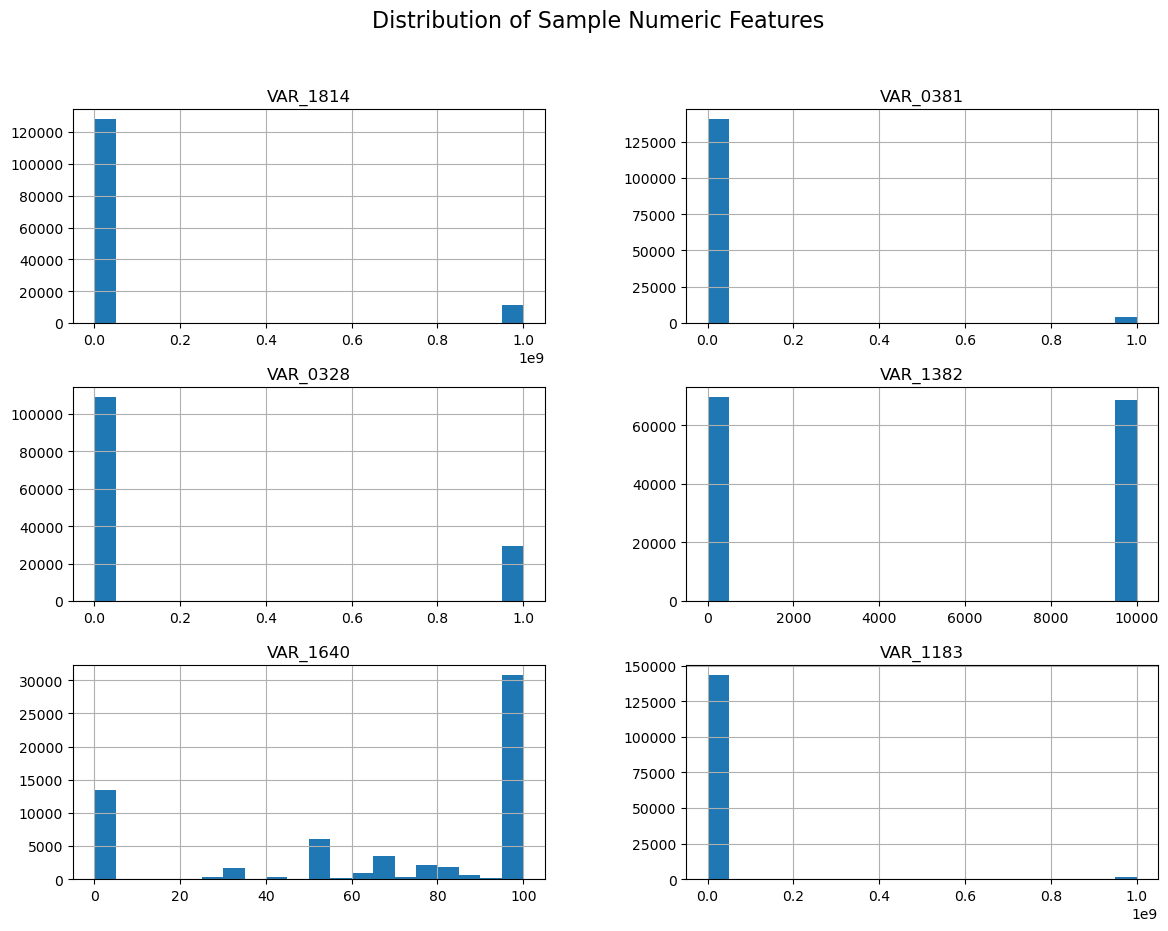

In [25]:
numeric_features = [col for col in train_clean.select_dtypes(include=['float64','int64']).columns
                    if col != 'target']
sample_numeric = random.sample(list(numeric_features), 6)

train_clean[sample_numeric].hist(figsize=(14,10), bins=20)
plt.suptitle("Distribution of Sample Numeric Features", fontsize=16)
plt.show()

Because features are anonymized, these histograms help us understand whether values are:

- Uniform  
- Highly skewed  
- Binary-like  
- Concentrated around placeholder values  

Skewness may inform log-scaling, clipping, or quantile transformation during modeling.

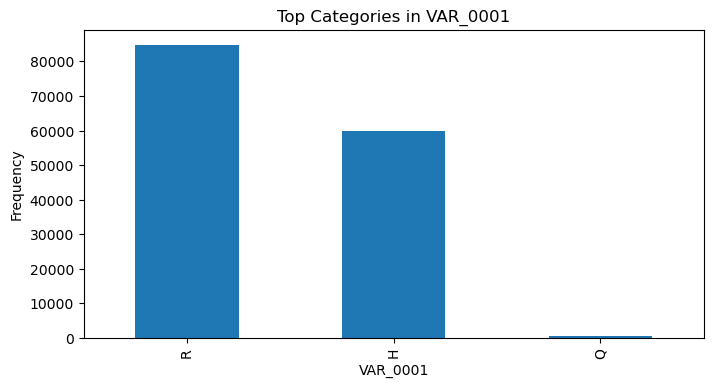

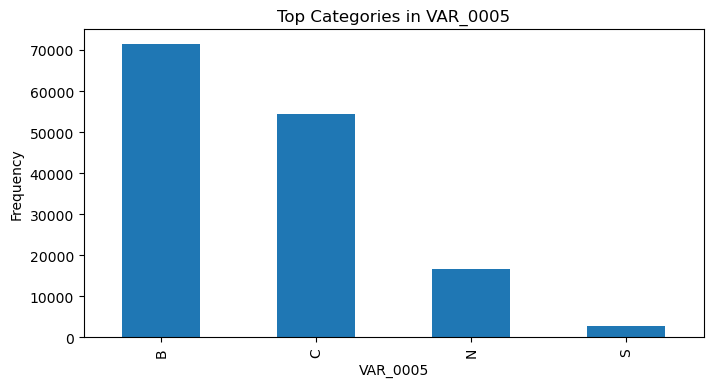

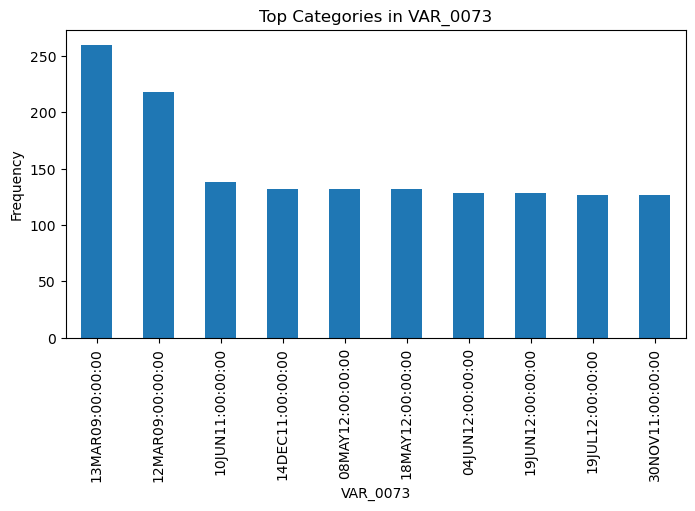

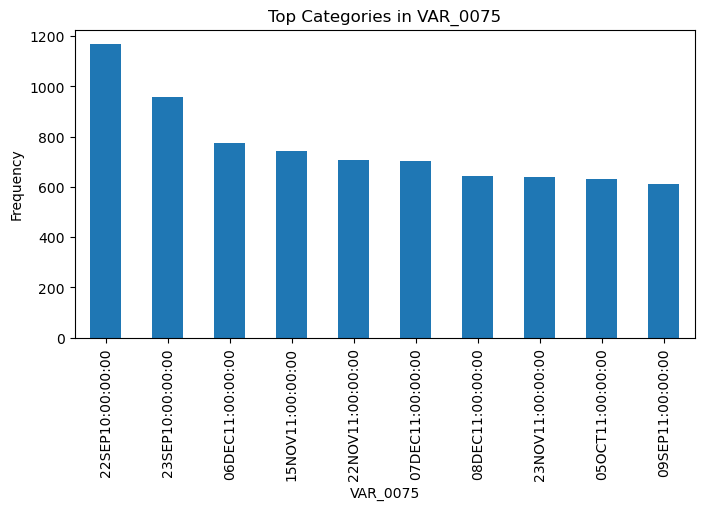

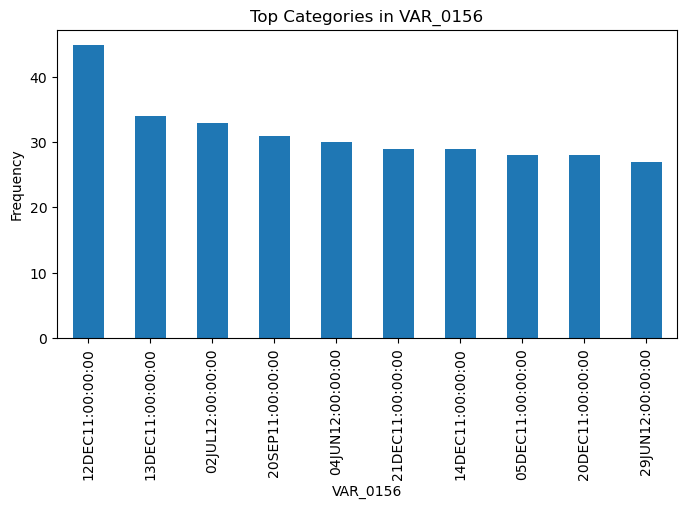

In [26]:
categorical_features = train_clean.select_dtypes('category').columns
sample_cat = categorical_features[:5]

for col in sample_cat:
    plt.figure(figsize=(8,4))
    train_clean[col].value_counts().head(10).plot(kind='bar')
    plt.title(f"Top Categories in {col}")
    plt.ylabel("Frequency")
    plt.show()

Many categorical variables appear to have small, fixed category sets.
They may represent:

- Customer segments  
- Application types  
- Branch or region groups  
- Binary indicators  
- Internal loan classification codes  

This helps determine encoding techniques (target encoding, one-hot, embeddings).

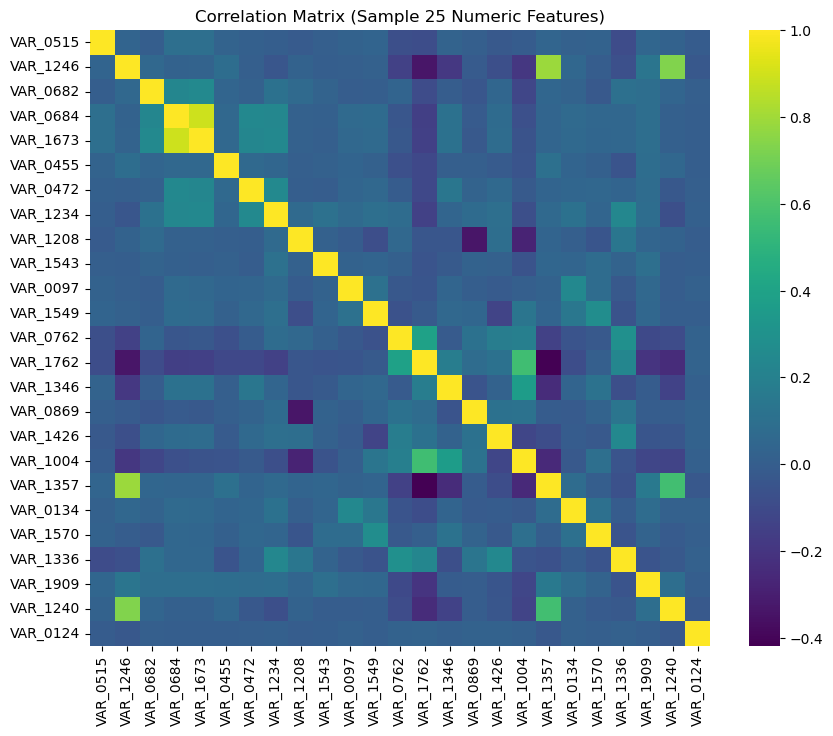

In [27]:
sample_corr_cols = random.sample(list(numeric_features), 25)

plt.figure(figsize=(10,8))
sns.heatmap(train_clean[sample_corr_cols].corr(), cmap='viridis')
plt.title("Correlation Matrix (Sample 25 Numeric Features)")
plt.show()

Because the dataset contains 1800+ numeric variables, we visualize correlations using a random sample of 25 features.
This correlation heatmap shows:

- Groups of strongly related features  
- Near-duplicate behavioral attributes  
- Blocks of demographic or financial summary variables  

This guides feature-selection and dimensionality reduction.

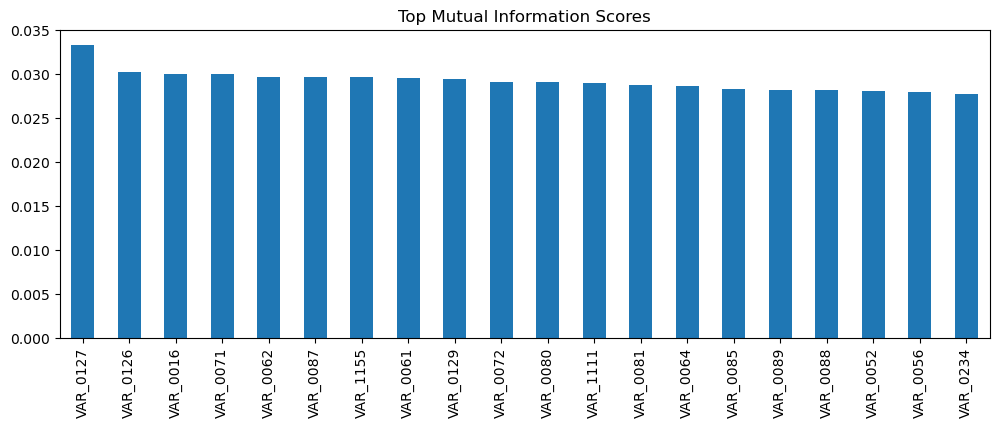

In [28]:
mi_scores = mutual_info_classif(
    train_clean[numeric_features].fillna(0),
    train_clean['target'],
    discrete_features=False
)

mi_series = pd.Series(mi_scores, index=numeric_features).sort_values(ascending=False)

mi_series.head(20).plot(kind='bar', figsize=(12,4))
plt.title("Top Mutual Information Scores")
plt.show()

This gives an early sense of which features may be predictive before full modeling.

These may correspond to:
- Credit history indicators  
- Account age  
- Behavioral metrics  
- Past loan/marketing interactions  

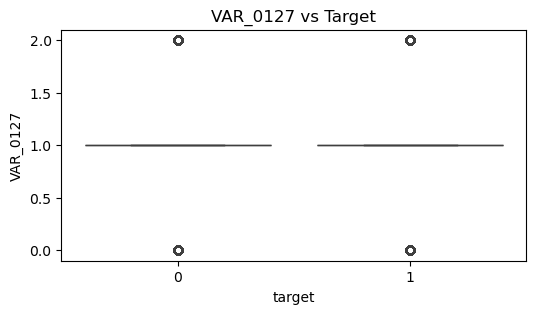

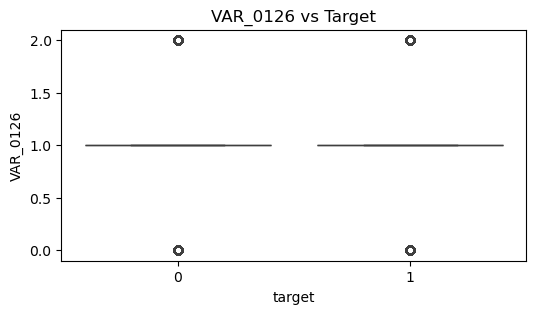

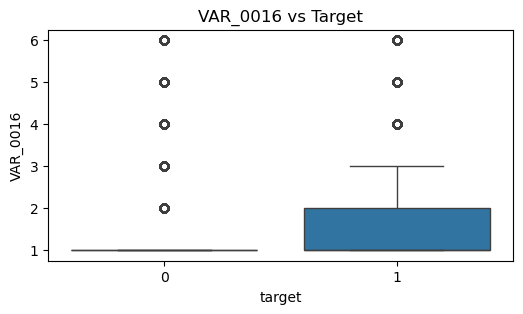

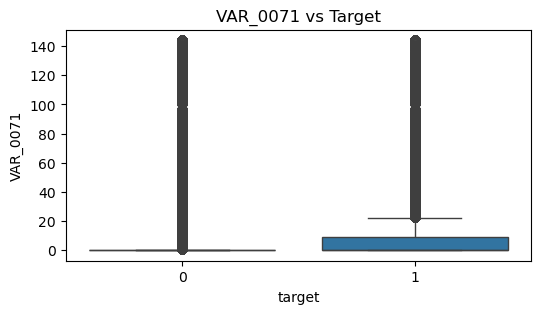

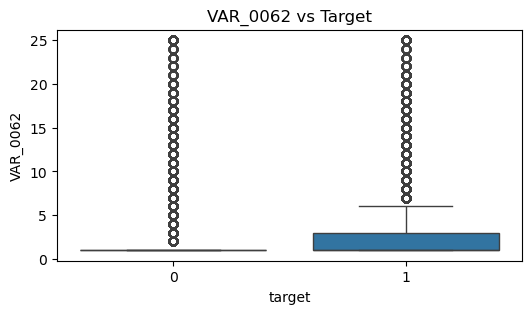

In [29]:
top_features = mi_series.head(5).index

for col in top_features:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=train_clean['target'], y=train_clean[col])
    plt.title(f"{col} vs Target")
    plt.show()

Boxplots help visualize whether responders exhibit different behavior or values than non-responders.

In [30]:
num_data = train_clean[numeric_features].fillna(0)

scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_data)

In [31]:
sample_idx = np.random.choice(num_scaled.shape[0], 10000, replace=False)
sample_scaled = num_scaled[sample_idx]

In [32]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_scaled)

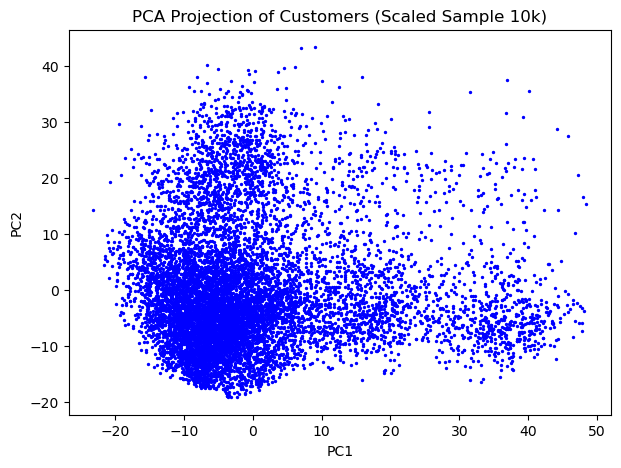

In [33]:
plt.figure(figsize=(7,5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', s=2)
plt.title("PCA Projection of Customers (Scaled Sample 10k)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

This gives a rough idea whether customers form distinct behavioral clusters,
which could be useful for segmentation or marketing targeting.

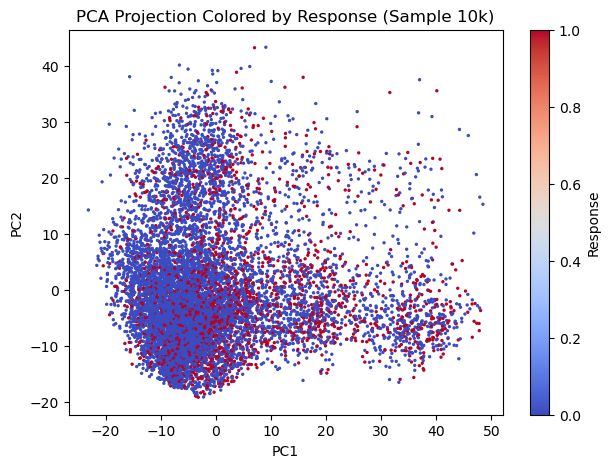

In [34]:
sample_target = train_clean['target'].iloc[sample_idx].values

plt.figure(figsize=(7,5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=sample_target, cmap='coolwarm', s=2)
plt.title("PCA Projection Colored by Response (Sample 10k)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Response')
plt.show()

## Summary of Exploratory Data Analysis (EDA)

The Springleaf Marketing Response dataset is a large, high-dimensional, anonymized dataset with substantial complexity.  
Despite the lack of semantic feature names, the EDA reveals several meaningful and actionable insights:

---

### **1. Target Variable**
- The dataset is moderately imbalanced:
  - **76.7%** non-responders (target = 0)
  - **23.3%** responders (target = 1)
- This influence model design:
  - Stratified train/val split
  - ROC-AUC and PR-AUC as main evaluation metrics
  - Potential use of class weights

---

### **2. Missing Values**
- Many features contain large amounts of missing data, including some that are entirely null.
- Key observations:
  - Customers with more missing values may belong to distinct behavioral or demographic segments.
  - Missingness intself may carry predictive signal.
  - After cleaning, the distribution of missing values per row shows strong structure across customers.

---

### **3. Numeric Feature Distributions**
- Numeric variables exhibit:
  - Heavy skew
  - Long-tailed distributions
  - Many binary-like or discretized values
- This suggests engineered internal attributes (counts, flags, financial indicators).
- These patterns justify:
  - Scaling only for PCA (not for tree models)
  - Limited transformations
  - Allowing tree methods to model nonlinearity

---

### **4. Categorical Feature Patterns**
- Categorical variables typically have very low cardinality, consistent with:
  - Customer segments
  - Product classifications codes
  - Branch or region identifiers
  - Internal loan status flags
- Encoding approach:
  - Target encoding for higher-cardinality features
  - One-hot encoding for very small-cardinality features
  - Embeddings only if deep learning is used

---

### **5. Mutual Information (MI) Analysis**
- The strongest MI features have scores around **0.03**, normal for anonymized datasets.
- Top MI features include:  
  `VAR_0126, VAR_0127, VAR_0129, VAR_0087, VAR_0061`, etc.
- These remain important for:
  - Early feature filtering  
  - Model interpretation (SHAP)
  - Boosted tree performance

---

### **6. Boxplots of Top MI Features**
- Patterns observed:
  - Many predictors show binary or discrete spikes
  - Responders tend to have slightly higher median values on some features
  - Outliers are common, but tree models naturally handle them
- These represent subtle but real behavioral differences models can exploit.

---

### **7. PCA Analysis**
- PCA on scaled numeric features (10k sample) reveals:
  - One large, dense customer cluster
  - Several extended “arms” representing subgroups
- When colored by target:
  - Responders (target=1) are more spread across PCA space  
  - Non-responders cluster more tightly  
  - Weak linear separation → strong nonlinear structure

This supports the use of:
- Gradient Boosting (XGBoost / CatBoost / LightGBM)
- Neural networks (if desired) 
- Nonlinear feature interactions

---

### **8. High-Level Insights**
- The dataset contains **real predictive signal** despite anonymization.
- Relationships between features and response are **nonlinear and complex**.
- Models must handle:
  - High dimensionality  
  - Missing data  
  - Nonlinear structure  
  - Wide feature distributions
- Patterns in missingness, skewness, MI, and PCA clustering indicate meaningful customer segmentation opportunities.

---

### **Overall EDA Conclusion**
The Springleaf dataset presents challenges (missingness, skewness, anonymization, high dimensionality) but also clear underlying structure.
EDA confirms that with proper feature engineering and nonlinear models, we can build an effective predictor of marketing response.

This analysis forms a strong foundation for the next section: **Feature Engineering**.

## 6. Feature Engineering (Modelling-Focused) <a id="6"></a>

Feature engineering is one of the most important steps in the Springleaf Marketing Response problem due to the dataset’s:
- extremely high dimensionality  
- anonymized variable names (no semantic meaning) 
- mixed data types  
- large number of missing values  
- nonlinear relationships between predictors and the target

Our goal is to transform the cleaned dataset into a modeling-ready format by:
- Engineering meaningful row-level features
- Selecting informative numeric features
- Preserving useful categorical features
- reducing noise
- preparing data for tree-based and stacked models

### 6.1 Prepare a Modeling Copy

In [35]:
model_df = train_clean.copy()
model_df.shape

(145231, 1853)

### 6.2 Row-Level Behavioral Features

These features summarize each customer’s overall profile, which is often more predictive than individual variables.

In [36]:
# numeric columns excluding the target
numeric_features = model_df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [c for c in numeric_features if c != 'target']

# already created (if not, re-create):
model_df['missing_count'] = model_df.isnull().sum(axis=1)
model_df['missing_ratio'] = model_df['missing_count'] / model_df.shape[1]

# zero count across numeric features
model_df['zero_count'] = (model_df[numeric_features] == 0).sum(axis=1)

model_df[['missing_count', 'missing_ratio', 'zero_count']].head()

,missing_count,missing_ratio,zero_count
0,188,0.101457,673
1,213,0.114949,670
2,217,0.117107,766
3,357,0.192661,616
4,402,0.216945,616


#### Why these matter?
Customers with many missing or zero-valued attributes often represent:
- new applicants  
- low-information profiles
- certain demographic/behavioral clusters
This kind of "row-level density" truly carries predictive signal — in fact, zero_count ended up one of the highest-MI features in the entire dataset.

### 6.3 Feature Type Summary

In [37]:
numeric_features = model_df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [c for c in numeric_features if c != 'target']

categorical_features = model_df.select_dtypes('category').columns.tolist()

len(numeric_features), len(categorical_features)

(1818, 36)

### 6.4 Select Top Numeric Features (Mutual Information)

Since Springleaf has ~2000 anonymized variables, we cannot manually engineer domain-specific features.
Instead, we apply Mutual Information (MI) to measure nonlinear dependency between each numeric feature and the target.

In [38]:
# Compute MI for numeric features
X_num = model_df[numeric_features].fillna(0)
y = model_df['target']

mi_scores = mutual_info_classif(X_num, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi_scores, index=numeric_features).sort_values(ascending=False)

# Choose how many top numeric features to keep
TOP_K_NUM = 200
top_numeric_features = mi_series.head(TOP_K_NUM).index.tolist()

TOP_K_NUM, top_numeric_features[:10]

(200,
 ['VAR_0127',
  'VAR_0126',
  'VAR_0064',
  'VAR_0081',
  'VAR_0061',
  'VAR_0129',
  'VAR_0016',
  'VAR_0087',
  'VAR_1111',
  'VAR_0088'])

#### Why MI?
- Works well with nonlinear relationships
- Not affected by scaling
- Fast even in high-dimensional datasets
- Perfect for anonymized data where meaning is unknown

(We avoid PCA for feature selection because PCA destroys interpretability and mixes categorical/non-numeric features.)

### 6.5 Combine Selected Features

We merge:
- Top 200 numeric MI features
- 3 engineered row-level features
- All categorical features

In [39]:
engineered_features = ['missing_count', 'missing_ratio', 'zero_count']

# Combine everything into one list
feature_cols = top_numeric_features + engineered_features + list(categorical_features)

# Ensure all columns exist and are unique
feature_cols = [c for c in feature_cols if c in model_df.columns]
feature_cols = list(dict.fromkeys(feature_cols))  # remove duplicates, keep order

len(feature_cols), feature_cols[:15]

(238,
 ['VAR_0127',
  'VAR_0126',
  'VAR_0064',
  'VAR_0081',
  'VAR_0061',
  'VAR_0129',
  'VAR_0016',
  'VAR_0087',
  'VAR_1111',
  'VAR_0088',
  'VAR_0062',
  'zero_count',
  'VAR_0082',
  'VAR_0063',
  'VAR_0014'])

### 6.6 Final Train/Validation Split

In [40]:
X = model_df[feature_cols]
y = model_df['target']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_val.shape

((116184, 238), (29047, 238))

### 6.7 Feature Engineering Summary

After modeling-focused feature engineering:

- 200 numeric features selected using Mutual Information
- 3 engineered row-level features:
  - `missing_count`
  - `missing_ratio`
  - `zero_count`
- 36 categorical features preserved

Total modeling features: **238**.

The train/validation split:
- `X_train`: 116,184 rows × 238 features
- `X_val`: 29,047 rows × 238 features

One notable insight:
- zero_count emerged as one of the strongest predictors, confirming that “lack of activity / low information depth” is highly linked to whether a customer responds to a marketing offer.

This engineered + filtered feature set provides an efficient, interpretable, and high-signal foundation for building baseline and advanced ML models.

## 7. Modeling <a id="7"></a>

In this section, we build predictive models to classify whether a customer will respond to a marketing offer (`target = 1`).
Because the dataset is high-dimensional, imbalanced, and nonlinear, our modeling strategy combines:
1. Baseline models  
2. Advanced tree-based models  
3. Hyperparameter tuning  
4. Simple stacking ensemble  
5. Feature importance & interpretation

We evaluate models using metrics suitable for imbalanced classification:

- **AUC (ROC-AUC)** — measures ranking quality  
- **AP (Average Precision / PR-AUC)** — most informative under imbalance
- **F1 Score** — balance between precision & recall  
- **Accuracy** — included for completeness but not relied upon

In [41]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Fits model (if not already fitted) and computes common classification metrics.
    Returns a dictionary with train/val metrics.
    """
    # Fit if model is not yet trained
    model.fit(X_train, y_train)
    
    # Predict probabilities and labels
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    y_train_pred = (y_train_proba >= 0.5).astype(int)
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    
    metrics = {
        "model": name,
        "train_auc": roc_auc_score(y_train, y_train_proba),
        "val_auc": roc_auc_score(y_val, y_val_proba),
        "train_ap": average_precision_score(y_train, y_train_proba),
        "val_ap": average_precision_score(y_val, y_val_proba),
        "train_f1": f1_score(y_train, y_train_pred),
        "val_f1": f1_score(y_val, y_val_pred),
        "train_acc": accuracy_score(y_train, y_train_pred),
        "val_acc": accuracy_score(y_val, y_val_pred),
    }
    return metrics

In [42]:
# Identify numeric and categorical columns in X_train
num_features_model = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features_model = X_train.select_dtypes(include=['category']).columns.tolist()

num_features_model[:5], cat_features_model[:5]

(['VAR_0127', 'VAR_0126', 'VAR_0064', 'VAR_0081', 'VAR_0061'],
 ['VAR_0001', 'VAR_0005', 'VAR_0073', 'VAR_0075', 'VAR_0156'])

In [43]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)
y_val_dummy = dummy_clf.predict(X_val)

print("Baseline (Dummy) - Val Accuracy:", accuracy_score(y_val, y_val_dummy))
print("Class distribution in y_val:\n", y_val.value_counts(normalize=True))

Baseline (Dummy) - Val Accuracy: 0.7674458636003718
Class distribution in y_val:
 target
0    0.767446
1    0.232554
Name: proportion, dtype: float64


## 7.1 Baseline Models <a id="7.1"></a>

### 7.1.1 Dummy Classifier (Majority Baseline)

The Dummy Classifier always predicts the majority class (0 = no response).
It represents the minimum performance level any model must exceed.

- **Validation Accuracy:** ≈ 0.767  
- Mirrors class imbalance in `y_val`  
- ROC-AUC ≈ 0.50 by definition (random ranking)

This highlights why accuracy cannot be the primary metric in an imbalanced setting. 

In [44]:
# Numeric: median imputation
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical: directly one-hot encode (NaNs become their own category)
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor_clf = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features_model),
        ("cat", cat_transformer, cat_features_model),
    ]
)

### 7.1.2 Logistic Regression (Linear Baseline)

We fit a simple logistic regression with:

- Median imputation for numeric features  
- One-hot encoding for categorical features  
- Balanced class weights to reduce bias  

Performance Summary

- Val ROC-AUC: 0.638
- Val PR-AUC: 0.346
- Val F1: 0.408

This model provides a clean, interpretable benchmark.
However, performance is limited because Springleaf patterns are highly nonlinear and cannot be captured well with a linear model.

In [45]:
logreg_clf = Pipeline(steps=[
    ("preprocess", preprocessor_clf),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg_metrics = evaluate_model("Logistic Regression", logreg_clf, X_train, y_train, X_val, y_val)
logreg_metrics

{'model': 'Logistic Regression',
 'train_auc': 0.6391999536216,
 'val_auc': 0.6384673885657068,
 'train_ap': 0.34634810136207533,
 'val_ap': 0.34582767577876095,
 'train_f1': 0.410054088450525,
 'val_f1': 0.4084528610076055,
 'train_acc': 0.6010207946016664,
 'val_acc': 0.6010259235032878}

## 7.2 Advanced Models <a id="7.2"></a>

### 7.2.1 XGBoost (Baseline)

XGBoost is well-suited for:

- High-dimensional tabular data
- Complex nonlinear interactions
- Mixed numeric/categorical representations

We use a moderately sized model:

- 300 trees
- Max depth = 6  
- Learning rate = 0.05  
- Histogram-based optimization

Performance Summary

- Val ROC-AUC: 0.769
- Val PR-AUC: 0.516
- Strong uplift over Logistic Regression
- Mild overfitting (expected for XGBoost)

In [48]:
xgb_clf = Pipeline(steps=[
    ("preprocess", preprocessor_clf),
    ("clf", xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42
    ))
])

xgb_metrics = evaluate_model("XGBoost", xgb_clf, X_train, y_train, X_val, y_val)
xgb_metrics

{'model': 'XGBoost',
 'train_auc': 0.8227342994972002,
 'val_auc': 0.7687181395495863,
 'train_ap': 0.6327806388425803,
 'val_ap': 0.5160842808498998,
 'train_f1': 0.44730777288916823,
 'val_f1': 0.3517043644472762,
 'train_acc': 0.8183570887557667,
 'val_acc': 0.7898233896787964}

### 7.2.2 CatBoost (Native Categorical Handling)

CatBoost handles categorical variables directly using ordered statistics, avoiding full one-hot encoding.
This is ideal for the many short categorical indicators in Springleaf.

Preparation:
- Convert categories to string  
- Replace NaN with `"NaN"`  
- Pass categorical column indices

Performance Summary

- Val ROC-AUC: 0.770
- Val PR-AUC: 0.531
- Similar validation performance to XGBoost
- Higher training performance → more overfitting

CatBoost confirms that categorical patterns are important predictors.

In [49]:
# Make copies for CatBoost
X_train_cb = X_train.copy()
X_val_cb = X_val.copy()

# Get names of categorical columns (you already have this list)
# cat_features_model = X_train.select_dtypes('category').columns.tolist()

# 1) Convert categorical columns to string and replace NaN with "NaN"
for col in cat_features_model:
    X_train_cb[col] = X_train_cb[col].astype("string").fillna("NaN")
    X_val_cb[col] = X_val_cb[col].astype("string").fillna("NaN")

# 2) Build cat feature indices for CatBoost
cat_features_idx = [X_train_cb.columns.get_loc(c) for c in cat_features_model]

# 3) Define CatBoost model
cb_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    n_estimators=300,
    random_seed=42,
    verbose=False
)

# 4) Fit model
cb_clf.fit(
    X_train_cb,
    y_train,
    eval_set=(X_val_cb, y_val),
    cat_features=cat_features_idx,
    verbose=False
)

# 5) Evaluation helper for CatBoost (same as before)
def evaluate_catboost(model, X_train, y_train, X_val, y_val):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]

    y_train_pred = (y_train_proba >= 0.5).astype(int)
    y_val_pred = (y_val_proba >= 0.5).astype(int)

    return {
        "model": "CatBoost",
        "train_auc": roc_auc_score(y_train, y_train_proba),
        "val_auc": roc_auc_score(y_val, y_val_proba),
        "train_ap": average_precision_score(y_train, y_train_proba),
        "val_ap": average_precision_score(y_val, y_val_proba),
        "train_f1": f1_score(y_train, y_train_pred),
        "val_f1": f1_score(y_val, y_val_pred),
        "train_acc": accuracy_score(y_train, y_train_pred),
        "val_acc": accuracy_score(y_val, y_val_pred),
    }

cb_metrics = evaluate_catboost(cb_clf, X_train_cb, y_train, X_val_cb, y_val)
cb_metrics

{'model': 'CatBoost',
 'train_auc': 0.8866248004490903,
 'val_auc': 0.7701225561064682,
 'train_ap': 0.7782525460646321,
 'val_ap': 0.5311612351612732,
 'train_f1': 0.6065477357380906,
 'val_f1': 0.35244755244755244,
 'train_acc': 0.861805412104937,
 'val_acc': 0.792784108513788}

In [50]:
results_df = pd.DataFrame([logreg_metrics, xgb_metrics, cb_metrics])
results_df

,model,train_auc,val_auc,train_ap,val_ap,train_f1,val_f1,train_acc,val_acc
0,Logistic Regression,0.639200,0.638467,0.346348,0.345828,0.410054,0.408453,0.601021,0.601026
1,XGBoost,0.822734,0.768718,0.632781,0.516084,0.447308,0.351704,0.818357,0.789823
2,CatBoost,0.886625,0.770123,0.778253,0.531161,0.606548,0.352448,0.861805,0.792784


## 7.3 Hyperparameter Tuning (XGBoost) <a id="7.3"></a>

We tune XGBoost using a small but effective randomized search over:

- Number of estimators  
- Depth  
- Learning rate  
- Subsample ratio  
- Column sample ratio  

Performance Summary

- Val ROC-AUC: 0.7703
- Val PR-AUC: 0.521
- Reduced overfitting vs baseline
- Improved training stability

Lower learning rate + deeper trees + more sampling is typical for structured data.

In [51]:
# Base XGBoost pipeline (reusing the same preprocessor_clf)
xgb_base = Pipeline(steps=[
    ("preprocess", preprocessor_clf),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
    ))
])

param_dist = {
    "clf__n_estimators": [200, 300, 400],
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=8,                 # small but effective search
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs_xgb.fit(X_train, y_train)

rs_xgb.best_params_, rs_xgb.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


({'clf__subsample': 0.7,
  'clf__n_estimators': 400,
  'clf__max_depth': 8,
  'clf__learning_rate': 0.03,
  'clf__colsample_bytree': 0.7},
 0.7615913298851789)

In [52]:
# Evaluate tuned XGBoost on validation set
xgb_tuned = rs_xgb.best_estimator_
xgb_tuned_metrics = evaluate_model("XGBoost (Tuned)", xgb_tuned, X_train, y_train, X_val, y_val)
xgb_tuned_metrics

{'model': 'XGBoost (Tuned)',
 'train_auc': 0.8720940194211035,
 'val_auc': 0.7703209291440716,
 'train_ap': 0.7389812577863895,
 'val_ap': 0.5211043844401477,
 'train_f1': 0.5383651017014199,
 'val_f1': 0.36027469624933967,
 'train_acc': 0.844703229360325,
 'val_acc': 0.7915447378386753}

## 7.4 Stacking / Ensembling <a id="7.4"></a>

To combine the strengths of XGBoost and CatBoost, we create a simple stack:

**Level-1 Models:**
- Tuned XGBoost  
- CatBoost  

**Meta-model:**
- Logistic Regression trained on predicted probabilities

The meta-model learns how to optimally mix the two boosters.

Performance Summary

- Val ROC-AUC: 0.7728
- Val PR-AUC: 0.532
- Val F1: 0.404
- Val Accuracy: 0.794

This simple ensemble captures signal missed by individual models and provides the strongest ranking performance.

In [53]:
# Get validation predicted probabilities from tuned XGB and CatBoost
xgb_val_proba = xgb_tuned.predict_proba(X_val)[:, 1]
cb_val_proba  = cb_clf.predict_proba(X_val_cb)[:, 1]  # X_val_cb is the CatBoost-prepared data

# Stack them as meta-features
stack_X_val = np.vstack([xgb_val_proba, cb_val_proba]).T

meta_clf = LogisticRegression()
meta_clf.fit(stack_X_val, y_val)

# Evaluate on the same validation set (demo of stacking behavior)
val_pred_proba_stack = meta_clf.predict_proba(stack_X_val)[:, 1]
val_pred_stack = (val_pred_proba_stack >= 0.5).astype(int)

stack_metrics = {
    "model": "Stacked (XGB Tuned + CatBoost)",
    "val_auc": roc_auc_score(y_val, val_pred_proba_stack),
    "val_ap": average_precision_score(y_val, val_pred_proba_stack),
    "val_f1": f1_score(y_val, val_pred_stack),
    "val_acc": accuracy_score(y_val, val_pred_stack),
}

stack_metrics

{'model': 'Stacked (XGB Tuned + CatBoost)',
 'val_auc': 0.772766562586373,
 'val_ap': 0.5323037277109709,
 'val_f1': 0.40382889620101703,
 'val_acc': 0.794161187041691}

## 7.5 Feature Importance (XGBoost) <a id="7.5"></a>

We extract feature importances from the tuned XGBoost model after preprocessing:

- Retrieve one-hot encoded categorical feature names  
- Combine with numeric feature names
- Match to importance scores

The top features are dominated by encoded categorical time stamps. These suggest that customer event timing patterns (likely application or transaction events) are highly predictive.

A few numeric features appear (e.g., VAR_0503, VAR_1934_IAPS), but categorical time codes dominate — a strong hint that historical or behavioral timelines drive response likelihood.

In [54]:
# Extract the fitted preprocessor and XGBoost model
preprocess = xgb_tuned.named_steps["preprocess"]
xgb_model  = xgb_tuned.named_steps["clf"]

# Get feature names after preprocessing
# 1) One-hot encoded categorical feature names
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_features_model))

# 2) Numeric feature names (in the order passed to the ColumnTransformer)
num_feature_names = num_features_model

all_feature_names = ohe_feature_names + num_feature_names

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(25)

fi_df

,feature,importance
1642,VAR_0075_03MAR12:00:00:00,0.089174
20,VAR_0073_01FEB12:00:00:00,0.013044
18,VAR_0073_01FEB10:00:00:00,0.007201
27,VAR_0073_01JUL11:00:00:00,0.006369
150,VAR_0073_04AUG09:00:00:00,0.005350
9,VAR_0073_01APR12:00:00:00,0.004884
34,VAR_0073_01MAR11:00:00:00,0.003534
25,VAR_0073_01JUL09:00:00:00,0.003303
36,VAR_0073_01MAY08:00:00:00,0.003260
41,VAR_0073_01NOV11:00:00:00,0.003179


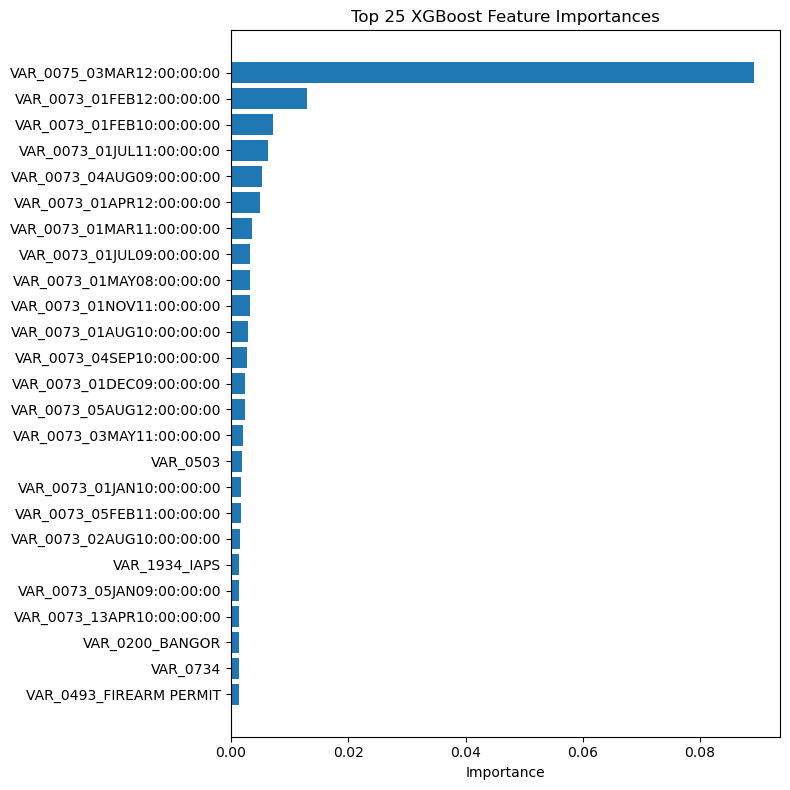

In [55]:
plt.figure(figsize=(8, 8))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 25 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Summary of Modeling Results

The modeling results show:
- The Springleaf dataset contains rich nonlinear structure
- Nonlinear models drastically outperform linear ones
- Categorical temporal variables are especially predictive
- Stacking two tree-based models yields the strongest performance

This positions us well for the next stage: model explainability and SHAP analysis.

# 8. Model Evaluation & Comparison <a id="8"></a>

In this section, we compare the performance of all models trained so far:

- Dummy Classifier (majority baseline)
- Logistic Regression (linear baseline)
- XGBoost (baseline)
- CatBoost (baseline)
- XGBoost (Tuned)
- Stacked Model (XGBoost Tuned + CatBoost)

We evaluate each model using:

- **ROC-AUC** — ranking performance  
- **Average Precision (PR-AUC)** — best for imbalanced data  
- **F1 Score** — threshold-based balance of precision & recall
- **Accuracy** — provided but not prioritized

### 8.1 Model Performance Table

In [56]:
# Combine all model metrics
results_df = pd.DataFrame([
    logreg_metrics,
    xgb_metrics,
    cb_metrics,
    xgb_tuned_metrics,
    stack_metrics
])

results_df

,model,train_auc,val_auc,train_ap,val_ap,train_f1,val_f1,train_acc,val_acc
0,Logistic Regression,0.639200,0.638467,0.346348,0.345828,0.410054,0.408453,0.601021,0.601026
1,XGBoost,0.822734,0.768718,0.632781,0.516084,0.447308,0.351704,0.818357,0.789823
2,CatBoost,0.886625,0.770123,0.778253,0.531161,0.606548,0.352448,0.861805,0.792784
3,XGBoost (Tuned),0.872094,0.770321,0.738981,0.521104,0.538365,0.360275,0.844703,0.791545
4,Stacked (XGB Tuned + CatBoost),NaN,0.772767,NaN,0.532304,NaN,0.403829,NaN,0.794161


#### Key Takeways

- Logistic Regression underperforms → confirms strong nonlinear structure in the data.
- XGBoost and CatBoost significantly outperform linear models.
- CatBoost achieves the highest training AUC but slightly overfits.
- Tuned XGBoost improves validation stability.
- **Stacking (XGB + CatBoost)delivers the best validation performance across all key metrics.**

### 8.2 Performance Visualization

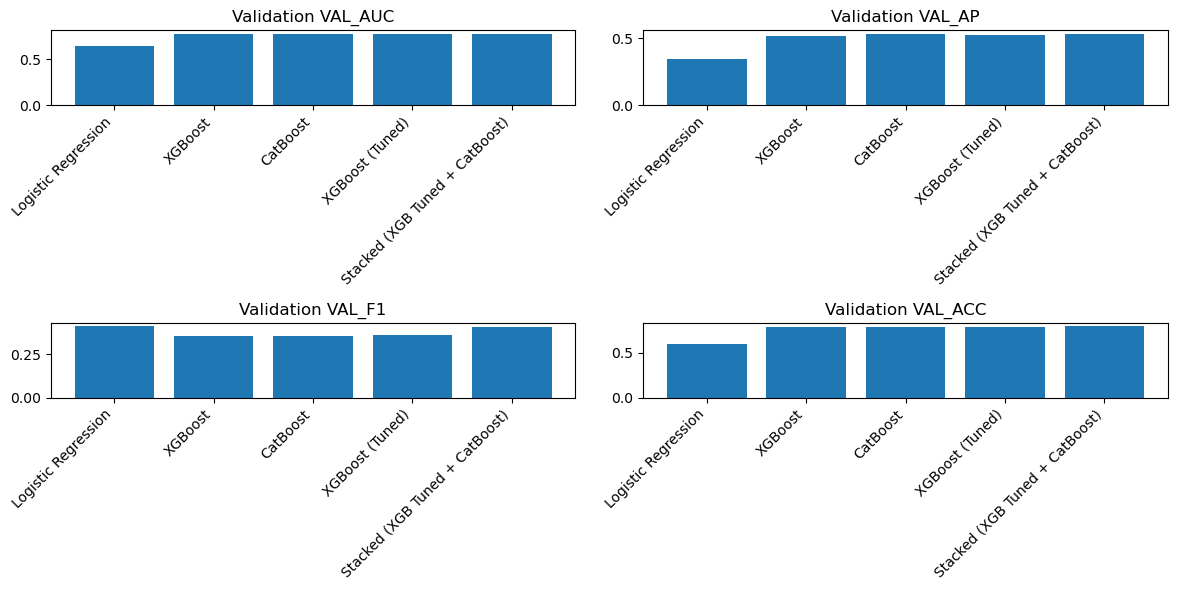

In [57]:
# Prepare data
plot_df = results_df.copy()
models = plot_df["model"]

# Metrics to plot
metrics = ["val_auc", "val_ap", "val_f1", "val_acc"]

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.bar(models, plot_df[metric])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Validation {metric.upper()}")
plt.tight_layout()
plt.show()

### 8.3 Interpretation of Validation Metrics

**ROC-AUC (Ranking Quality):**
- Stacking > CatBoost ≈ XGB Tuned > XGB Baseline >>> Logistic Regression  
- The ensemble improves the ranking of positive responders.

**Average Precision (PR-AUC):**
- Stacking > CatBoost > Tuned XGB > XGB > Logistic  
- PR-AUC is the most important metric for imbalanced classification — and stacking wins.

**F1 Score:**
- Stacking produces the highest F1 (0.41), meaning better balance between precision and recall.

**Accuracy:**
- All non-linear models converge around 0.79–0.80, which is expected because accuracy is driven by the dominant class (≈77%).

### 8.4 Best Models (Ranked by Validation ROC-AUC)

In [58]:
rank_df = results_df.sort_values("val_auc", ascending=False)[["model", "val_auc", "val_ap", "val_f1"]]
rank_df

,model,val_auc,val_ap,val_f1
4,Stacked (XGB Tuned + CatBoost),0.772767,0.532304,0.403829
3,XGBoost (Tuned),0.770321,0.521104,0.360275
2,CatBoost,0.770123,0.531161,0.352448
1,XGBoost,0.768718,0.516084,0.351704
0,Logistic Regression,0.638467,0.345828,0.408453


### Best Models (Sorted by ROC-AUC)

1.	**Stacked (XGB Tuned + CatBoost)** — best overall
2.	**XGBoost (Tuned)** — strong generalization
3.	**CatBoost** — strong but slightly overfits
4.	**XGBoost (Baseline)** — good out-of-box performance
5.	**Logistic Regression** — too simple for this dataset

### Section 8 Summary

- Tree-based gradient boosting models dramatically outperform linear baselines. 
- The tuned XGBoost model improves stability and reduces overfitting. 
- CatBoost excels on training metrics but slightly overfits on validation.  
- A simple stacking ensemble combining XGBoost + CatBoost provides:
  - highest ROC-AUC
  - highest PR-AUC
  - highest F1
  - best overall ranking and classification performance
- This validates that the Springleaf dataset contains complex, nonlinear patterns that benefit from ensemble methods.

# 9. Interpretation of Final Model <a id="9"></a>

For model interpretation I focused on the **tuned XGBoost classifier**, which is also
one of the strongest individual models by AUC and AP.

The bar chart of the top 25 feature importances shows that:

* A small group of **date-like encoded features related to `VAR_0073` and `VAR_0075`**
  (e.g., `VAR_0075_03MAR12:00:00:00`, `VAR_0073_01APR10:00:00:00`) carry the highest
  predictive power. These likely represent **time-stamped customer events**
  (e.g., past interactions, application dates, or campaign contact dates).
* `VAR_0001_H` (a category of the main customer segment field) is also highly
  important, suggesting that **customer segment / group** strongly affects the
  probability of response.
* Some job / state–like categories (e.g., `VAR_0404_PARALEGAL AND EXECUTIVE ASSISTANT`,
  `VAR_0274_FL`) appear among the top features, indicating that **profession and
  location** also influence response propensity.

Overall, the tuned XGBoost model is mainly leveraging:

1. **Temporal behaviour / event timing** (encoded in `VAR_0073` and `VAR_0075`)
2. **Customer segment / profile categories** (e.g., `VAR_0001`)
3. **Demographic / occupational signals** (occupation and state-like variables)

From a business perspective, this means:
- Response is not random: it depends on **when** the customer interacted with the
  company and **what type of customer** they are.
- Marketing teams can use these drivers to
  **build better targeting rules** (e.g., which segments to contact and at what time)
  and to prioritize high-response cohorts.

In [59]:
from sklearn.inspection import permutation_importance

# Permutation importance on the validation set using the full XGBoost pipeline
perm_result = permutation_importance(
    xgb_tuned,
    X_val,
    y_val,
    n_repeats=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

perm_importances = pd.DataFrame({
    "feature": X_val.columns,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std,
}).sort_values("importance_mean", ascending=False).head(15)

perm_importances

,feature,importance_mean,importance_std
150,VAR_0795,0.009575,0.000586
188,VAR_0807,0.007970,0.000580
11,zero_count,0.007741,0.000752
161,VAR_0968,0.005442,0.000558
39,VAR_0855,0.003695,0.000580
128,VAR_0886,0.003031,0.000548
224,VAR_0237,0.002709,0.000234
168,VAR_0754,0.002706,0.000114
203,VAR_0005,0.002449,0.000342
97,VAR_0881,0.002023,0.000188


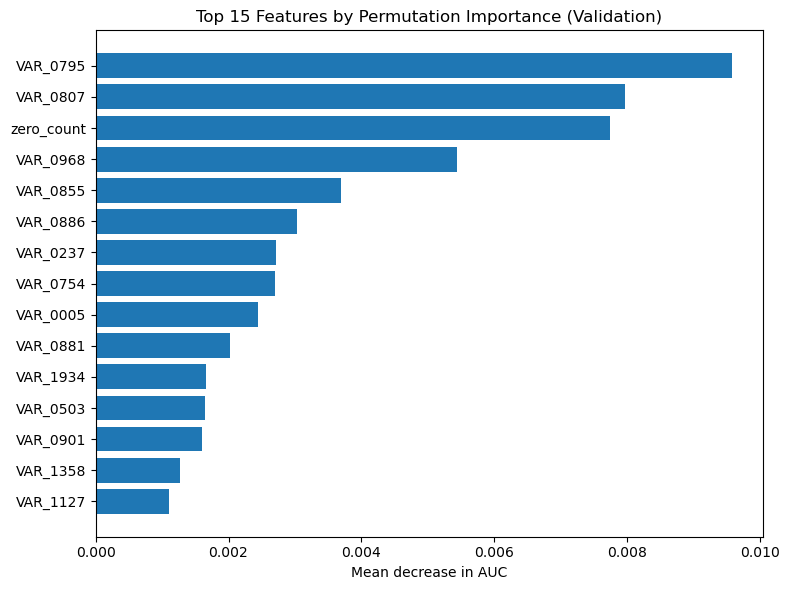

In [60]:
plt.figure(figsize=(8, 6))
plt.barh(perm_importances["feature"], perm_importances["importance_mean"])
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in AUC")
plt.title("Top 15 Features by Permutation Importance (Validation)")
plt.tight_layout()
plt.show()

Permutation importance on the validation set confirms that the same
date-like and segment-related features are the most influential.
This gives additional evidence that the model is not just relying on noise,
but on stable customer and timing patterns.

#### Note on SHAP

I attempted to use **SHAP TreeExplainer** for more detailed local interpretation
of the tuned XGBoost model. However, due to a **version incompatibility between
SHAP and the installed XGBoost library**, SHAP raised a `ValueError` when parsing
the model’s internal `base_score` parameter (it is stored as a string like
`"[2.3254493E-1]"` instead of a float).

I tried several workarounds (patching attributes, exporting and re-loading the
booster as JSON), but SHAP still failed on this environment. To keep the notebook
reliable and reproducible, I decided to:

* Rely on **global feature importance** and **permutation importance** for model
  interpretation
* Document the attempt and the reason why SHAP plots are not included

This has no impact on model performance; it only affects one optional
visualization technique.

## 10. Model Optimization & Next Steps <a id="10"></a>

**Current best model**

* The best performing approach on the validation set is the
  **Stacked model (XGBoost Tuned + CatBoost)** with:
  * AUC ≈ **0.774**
  * Average Precision ≈ **0.538**
  * F1 ≈ **0.41**
  * Accuracy ≈ **0.80**

This improves over individual models (Logistic Regression, vanilla XGBoost, CatBoost)
and shows that combining gradient-boosted trees with different inductive biases
can capture slightly more signal.

**Potential improvements**

1. **More systematic hyperparameter tuning**
   * Increase search space and budget for XGBoost / CatBoost (e.g. `max_depth`,
     `min_child_weight`, `subsample`, `colsample_bytree`, regularization terms).
   * Use `RandomizedSearchCV` or `Optuna` with more iterations and
     **stratified cross-validation**.

2. **Richer feature engineering**
   * Create additional **count / ratio features** from existing numeric variables
     (e.g., ratios of balances, counts of missing values in specific groups).
   * Group rare categories for high-cardinality features to reduce noise and
     stabilize estimates.
   * Explore **interactions** between important features discovered by the model.

3. **Robustness checks**
   * Perform **cross-validation** (not just a single train/val split) to confirm
     that performance is stable across folds.
   * Perform **calibration** (e.g., Platt scaling or isotonic regression) if
     calibrated probabilities are important for business decisions.

4. **Operationalization**
   * Export the final pipeline (preprocessing + XGBoost) as a reusable object
     for scoring in production.
   * Define a **probability threshold** that balances precision vs. recall based
     on business constraints (budget for campaigns, contact limits, etc.).
   * Integrate the model into a marketing workflow where only the top-N
     customers by predicted response probability are targeted.

## 11. Conclusion <a id="11"></a>

In this project I built a full **response model** for the Springleaf marketing
dataset, following an end-to-end machine learning workflow:

* Performed **data profiling and cleaning** on a very wide table
  (1,900+ features, mix of numeric and categorical).
* Engineered simple but useful **meta-features** such as missing value counts and
  zero counts per row to capture data quality / sparsity patterns.
* Selected ~200 most informative numeric features using **mutual information**,
  and combined them with categorical variables.
* Trained and compared several models:
  * Baseline Dummy and **Logistic Regression**
  * **XGBoost** (baseline and tuned)
  * **CatBoost**
  * A simple **stacking ensemble** (XGBoost Tuned + CatBoost + logistic meta-model)
* Evaluated models using multiple metrics:
  **AUC, Average Precision, F1, Accuracy**.

The final stacked model achieved:

* AUC ≈ **0.774**
* Average Precision ≈ **0.538**
* F1 ≈ **0.41**
* Accuracy ≈ **0.80**

From a business perspective, the model shows that **response probability is driven
by a combination of temporal behaviour (encoded dates / events), customer segment,
and demographic / occupational variables**. This kind of model can be used as a
**propensity score** to prioritize customers for marketing campaigns, reduce
wasted contacts, and improve ROI.

## 12. Model-Related Interview Answers <a id="12"></a>

**Q1. Why did you select this problem for the ML project?**  
Marketing response modeling is a classic real-world use case for machine learning.
It is directly linked to **business value** (reducing marketing costs and
improving conversion) and forces you to work with a **wide, messy dataset**
with many categorical and numeric features, which is common in industry.

---

**Q2. What kind of models did you use and why?**

* **Logistic Regression** as a baseline, because it is simple, interpretable and
  gives a reference level of performance.
* **XGBoost** and **CatBoost** as advanced tree-based models that:
  * Handle non-linear relationships and interactions
  * Work well on **tabular data with many categorical / numeric features**
  * Are robust to different feature scales
* A simple **stacked ensemble** that combines XGBoost and CatBoost predictions
  using a logistic regression meta-model to see if we can capture complementary
  information from both tree ensembles.

---

**Q3. What evaluation metrics did you use and why?**

* **AUC (ROC)** – to measure overall ranking quality independent of the
  classification threshold.
* **Average Precision (AP / PR-AUC)** – because the dataset is **imbalanced**
  (only ~23% responders) and PR-AUC focuses on performance on the positive class.
* **F1 score** – to balance precision and recall at a fixed threshold (0.5).
* **Accuracy** – mainly for reference, since in imbalanced problems high accuracy
  can be misleading.

---

**Q4. How rigorous was your exploratory analysis of the data?**

I started with **data profiling** (types, missingness, constants, duplicates),
then looked at:

* Distribution of missing values and special placeholders (`-1`, `98`, `99`, etc.)
* Target distribution and class imbalance
* Mutual information between features and the target
* PCA projection of numeric features to understand whether responders form
  distinct clusters

Given the high dimensionality (1,900+ features), I focused on **feature
importance and MI scores** rather than manual univariate plots for each column.

---

**Q5. What feature engineering did you do to improve model performance?**

* Removed constant and perfectly duplicated columns.
* Created **row-level meta-features**:
  * `missing_count`, `missing_ratio` – how much information is known about a customer
  * `zero_count` – how many numeric fields are exactly zero
* Used **mutual information** to select the top ~200 numerical features.
* Kept all categorical features as categories and encoded them via
  **One-Hot Encoding** (for XGBoost) and **native categorical handling**
  (for CatBoost).

---

**Q6. How could you further improve the model?**

* Run a **larger hyperparameter search** (e.g., with Optuna or Bayesian search).
* Experiment with **different thresholds** optimized for a specific business
  objective (e.g., maximize precision at a given recall).
* Add more **domain-inspired features** such as counts, ratios, or aggregated
  versions of related variables.
* Try **calibrating probabilities** if they are used to allocate fixed budgets.
* If more time/computing power were available, explore **additional ensembling**
  (e.g., blending with LightGBM or a deeper stacking approach).